In [19]:
import pandas as pd

recipesDF = pd.read_csv("recipes dataset/RAW_recipes.csv")
interactionsDF = pd.read_csv("recipes dataset/RAW_interactions.csv")    

In [2]:
import json
import gzip

def writeJSON(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)
def loadJSON(filename):
    with open(filename, 'r') as f:
        return json.load(f)


# load ratings, train, test, valid (80,10,10)

In [3]:
all_ratings = []
with open('processed_ratings.csv', 'r') as f:
    for line in f:
        all_ratings.append(line.strip().split(','))
        
all_ratings = all_ratings[1:]
ratings_train = all_ratings[:int(0.8*len(all_ratings))]
ratings_test = all_ratings[int(0.8*len(all_ratings)):int(0.9*len(all_ratings))]
ratings_valid = all_ratings[int(0.9*len(all_ratings)):]


# Load data structures

In [4]:
recipe_id_to_name = loadJSON("./data structures/recipe_id_to_name.json")
recipe_id_to_ingredients = loadJSON("./data structures/recipe_id_to_ingredients.json")
ratings_per_user = loadJSON("./data structures/ratings_per_user.json")
ratings_per_recipe = loadJSON("./data structures/ratings_per_recipe.json")
rating_date_per_user = loadJSON("./data structures/rating_date_per_user.json")
global_avg_rating = interactionsDF['rating'].mean()


# What I did to load data structures (darren)

In [29]:
import ast 
recipe_id_to_ingredients = {}
for i, row in recipesDF.iterrows():
    ingredients = row['ingredients']
    ingredientsList = ast.literal_eval(ingredients)
    recipe_id = row['id']
    recipe_id_to_ingredients[recipe_id] = ingredientsList
writeJSON("./data structures/recipe_id_to_ingredients.json", recipe_id_to_ingredients)

In [16]:
from collections import defaultdict
ratings_per_user = defaultdict(dict)
ratings_per_recipe = defaultdict(dict)
for index, row in interactionsDF.iterrows():
    user = row['user_id']
    recipe = row['recipe_id']
    rating = row['rating']
    ratings_per_user[user][recipe] = rating
    ratings_per_recipe[recipe][user] = rating
writeJSON("./data structures/ratings_per_user.json", ratings_per_user)
writeJSON("./data structures/ratings_per_recipe.json", ratings_per_recipe)

    


In [22]:
rating_date_per_user = defaultdict(dict)
for index, row in interactionsDF.iterrows():
    user = row['user_id']
    recipe = row['recipe_id']
    date = row['date']
    rating_date_per_user[user][recipe] = date
writeJSON("./data structures/rating_date_per_user.json", rating_date_per_user)

# User bias rating method (from homework 3)


In [30]:
betaU = {}
betaR = {}
for u in ratings_per_user:
    betaU[u] = 0

for r in ratings_per_recipe:
    betaR[r] = 0

In [31]:
alpha = global_avg_rating

In [ ]:
def iterate(lamb):
    newAlpha = 0
    for u,b,r in ratings_train:
        newAlpha += r - (betaU[u] + betaR[b])
    alpha = newAlpha / len(ratings_train)
    for u in ratings_per_user:
        newBetaU = 0
        for b,r in ratings_per_user[u]:
            newBetaU += r - (alpha + betaR[b])
        betaU[u] = newBetaU / (lamb + len(ratings_per_user[u]))
    for b in ratings_per_recipe:
        newbetaR = 0
        for u,r in ratings_per_recipe[b]:
            newbetaR += r - (alpha + betaU[u])
        betaR[b] = newbetaR / (lamb + len(ratings_per_recipe[b]))
    mse = 0
    for u,b,r in ratings_train:
        prediction = alpha + betaU[u] + betaR[b]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for b in betaR:
        regularizer += betaR[b]**2
    mse /= len(ratings_train)
    return mse, mse + lamb*regularizer

# Rachel

# SVD (Cuisine)

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

: 

In [ ]:
# Load datasets
recipesDF = pd.read_csv("RAW_recipes.csv")
interactionsDF = pd.read_csv("RAW_interactions.csv")

# Add 'cuisine' column (assume it's derived from tags or directly available)
recipesDF['cuisine'] = recipesDF['tags'].apply(lambda x: 'italian' if 'italian' in x else 'other')

# Merge interactions with recipes
recipesDF = recipesDF.rename(columns={'id': 'i'})
interactionsDF = interactionsDF.rename(columns={'user_id': 'u', 'recipe_id': 'i'})
merged_df = pd.merge(interactionsDF, recipesDF, on="i")

# Encode cuisines as integers for SVD
label_encoder = LabelEncoder()
merged_df['cuisine_encoded'] = label_encoder.fit_transform(merged_df['cuisine'])

# Prepare data for Surprise
reader = Reader(rating_scale=(0, len(label_encoder.classes_) - 1))
data = Dataset.load_from_df(merged_df[['u', 'i', 'cuisine_encoded']], reader)

## Akshay 

## RFC Classifier for Cuisines

In [21]:
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import ast
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [15]:
labeled_recipes = pd.read_csv("recipes dataset/RAW_recipes.csv")
labeled_recipes["ingredients"] = labeled_recipes["ingredients"].apply(ast.literal_eval)
labeled_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


In [16]:
# Consider the following cuisines - top 15 from https://www.farandwide.com/s/most-popular-cuisines-world-65478f832c624e5f
cuisines = set(["japanese", "italian", "indian", "korean", "thai", 
                "mexican", "chinese", "indonesian", "vietnamese", "filipino", 
                "greek", "french", "malaysian", "turkish", "peruvian",
                "nigerian", "spanish", "lebanese", "jamaican", "american",
                "brazilian", "persian", "moroccan", "german", "cuban",
                "polish", "dominican", "colombian"])

def label_recipes(dataframe):
    for ix, row in dataframe.iterrows():
        # Combine tags and recipe description to see if cuisine matches
        document_str = str(row["description"]).lower() + " " + " ".join(row["tags"])
        cuisine_counts = Counter (
            word for word in re.findall(r'\b\w+\b', document_str) if word in cuisines
        )
        if cuisine_counts:
            labeled_recipes.loc[ix, "cuisine"] = cuisine_counts.most_common(1)[0][0]
        else:
            labeled_recipes.loc[ix, "cuisine"] = "other"

    return labeled_recipes[labeled_recipes["cuisine"] != "other"].copy()

cuisine_df = label_recipes(labeled_recipes)
# Convert ingredients into string for vectorizer
cuisine_df["ingredients_str"] = labeled_recipes["ingredients"].str.join(" ")
cuisine_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cuisine,ingredients_str
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,mexican,winter squash mexican seasoning mixed spice ho...
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"[fennel seeds, green olives, ripe olives, garl...",9,italian,fennel seeds green olives ripe olives garlic p...
16,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5,mexican,egg roll wrap whole green chilies cheese corns...
44,italian sandwich pasta salad,33606,25,26278,2002-07-08,"['30-minutes-or-less', 'time-to-make', 'course...","[279.2, 14.0, 12.0, 22.0, 23.0, 11.0, 12.0]",6,"['cook pasta and set aside', 'place onions , d...",this is a fun salad that uses the same ingredi...,"[tri-color spiral pasta, dill pickles, ripe ol...",16,italian,tri-color spiral pasta dill pickles ripe olive...
45,italian fries,94710,15,44372,2004-06-30,"['15-minutes-or-less', 'time-to-make', 'course...","[241.0, 12.0, 1.0, 23.0, 10.0, 11.0, 12.0]",4,['deep fry french fries according to package d...,"ok, so this is not *really* italian, but it is...","[frozen french fries, oil, salt & freshly grou...",7,italian,frozen french fries oil salt & freshly ground ...


In [17]:
relative_counts = cuisine_df["cuisine"].value_counts()
relative_counts

cuisine
italian       3183
french        2557
mexican       1931
greek         1129
indian        1102
american      1088
chinese       1057
thai           773
german         747
spanish        605
japanese       466
moroccan       330
polish         226
cuban          174
vietnamese     162
turkish        159
korean         128
filipino       118
lebanese       102
persian        101
brazilian       97
indonesian      82
jamaican        76
peruvian        50
dominican       29
malaysian       28
colombian       22
nigerian        15
Name: count, dtype: int64

In [18]:
# Split data into training and test sets
train_data, test_data = train_test_split(cuisine_df, test_size=0.15, shuffle=True)

X_train, y_train = train_data["ingredients_str"], train_data["cuisine"]
X_test, y_test = test_data["ingredients_str"], test_data["cuisine"]

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [22]:
# Fit the RFC
test_accuracies = []
num_estimators = [50, 75, 100, 150, 200, 500, 1000]
best_clf = None
best_accuracy = 0
for estimators in num_estimators:
    clf = RandomForestClassifier(n_estimators=estimators)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    test_accuracies.append(accuracy)
    if best_clf is None or accuracy > best_accuracy:
        best_accuracy, best_clf = accuracy, clf
    print(f"Classifier accuracy for {estimators} estimators: {accuracy * 100}%.")

Classifier accuracy for 50 estimators: 55.70334542523177%.
Classifier accuracy for 75 estimators: 56.10640870616687%.
Classifier accuracy for 100 estimators: 56.187021362353896%.
Classifier accuracy for 150 estimators: 56.509471987101975%.
Classifier accuracy for 200 estimators: 56.791616283756554%.
Classifier accuracy for 500 estimators: 57.51713018943975%.
Classifier accuracy for 1000 estimators: 57.476823861346226%.


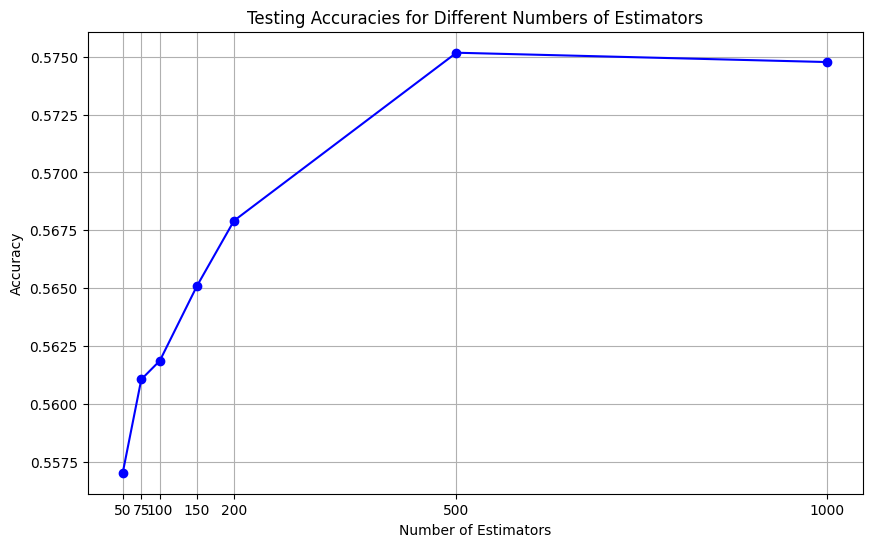

In [23]:
# Plot test accuracies of the various modelss
plt.figure(figsize=(10, 6))
plt.plot(num_estimators, test_accuracies, marker='o', linestyle='-', color='b')
plt.title('Testing Accuracies for Different Numbers of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(num_estimators)
plt.show()

In [24]:
def predict_cuisine(ingredients):
    ingredient_str = " ".join(ingredients)
    return best_clf.predict(tfidf.transform([ingredient_str]))[0]

In [25]:
predict_cuisine(["coriander", "butter", "garlic", "chicken", "salt"])

'french'